# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [105]:
%pip install gymnasium
%pip install matplotlib
%pip install Ipython
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [106]:
%pip install imageio

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
# import sys, os
# if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
#     !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
#     !touch .setup_complete

# # This code creates a virtual display to draw game images on.
# # It will have no effect if your machine has a monitor.
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
#     !bash ../xvfb start
#     os.environ['DISPLAY'] = ':1'

In [107]:
# Install gymnasium if you didn't
%pip install gymnasium[toy_text,classic_control]

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [108]:
import sys
sys.path.append('/home/jupyter/.local/lib/python3.10/site-packages')

In [109]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from IPython.display import clear_output
import multiprocessing as mp 

/home/jupyter/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
error: XDG_RUNTIME_DIR not set in the environment.


state vector dim = 4
n_actions = 2


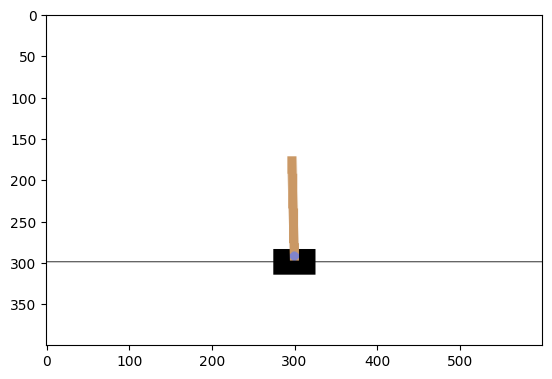

In [62]:
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [63]:

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [64]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(env.action_space.n,
                             p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward


In [65]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)


states: [[ 0.02363713 -0.00280054  0.01493868  0.02741213]
 [ 0.02358112  0.19210403  0.01548692 -0.2605203 ]
 [ 0.0274232   0.3870015   0.01027652 -0.5482785 ]
 [ 0.03516323  0.19173671 -0.00068905 -0.2523755 ]
 [ 0.03899796 -0.00337539 -0.00573657  0.04008998]]
actions: [1, 1, 0, 0, 1]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [66]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, q=percentile)

    elite_states = []
    elite_actions = []

    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return np.array(elite_states, dtype=np.float32), np.array(elite_actions, dtype=np.float32)


# Training loop
Generate sessions, select N best and fit to those.

In [67]:


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


mean reward = 210.063, threshold=238.600


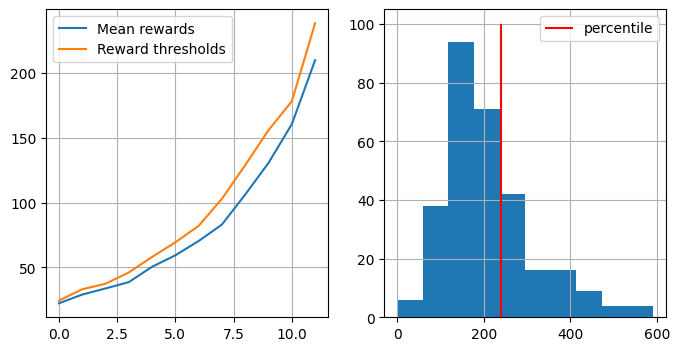

In [68]:
n_sessions = 300
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions) 
    show_progress(
        rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > 190:
       break


# Results

In [69]:
%pip install "gymnasium[other]"

Traceback (most recent call last):
  File "/kernel/lib/python3.10/site-packages/ml_kernel/_vendor/packaging/requirements.py", line 35, in __init__
    parsed = _parse_requirement(requirement_string)
  File "/kernel/lib/python3.10/site-packages/ml_kernel/_vendor/packaging/_parser.py", line 64, in parse_requirement
    return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
  File "/kernel/lib/python3.10/site-packages/ml_kernel/_vendor/packaging/_parser.py", line 73, in _parse_requirement
    name_token = tokenizer.expect(
  File "/kernel/lib/python3.10/site-packages/ml_kernel/_vendor/packaging/_tokenizer.py", line 140, in expect
    raise self.raise_syntax_error(f"Expected {expected}")
  File "/kernel/lib/python3.10/site-packages/ml_kernel/_vendor/packaging/_tokenizer.py", line 165, in raise_syntax_error
    raise ParserSyntaxError(
ml_kernel._vendor.packaging._tokenizer.ParserSyntaxError: Expected package name at the start of dependency specifier
    "gymnasium[other]"
    ^


In [16]:
import os
os.environ["XDG_RUNTIME_DIR"] = "/tmp"


In [17]:
from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("CartPole-v0", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
C:\Users\1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\1\vscode-projects\Practical_RL-1\week01_intro\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [18]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


## Task 1.1
I will divide experiments into three parts: how algrotithm perfomance changes if i use 

1. diff percentiles

2. diff n_sessions

3. both

Tbh at least in the first two variants we will not notice much difference when changing parameters, as it is trained the same way plus or minus from some values. But with the combination (3rd variant) we can already notice changes.

### First experiment 


n_sessions = 250  # sample this many sessions

percentile = 10 # discard this percentage of sessions with lowest rewards

learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1



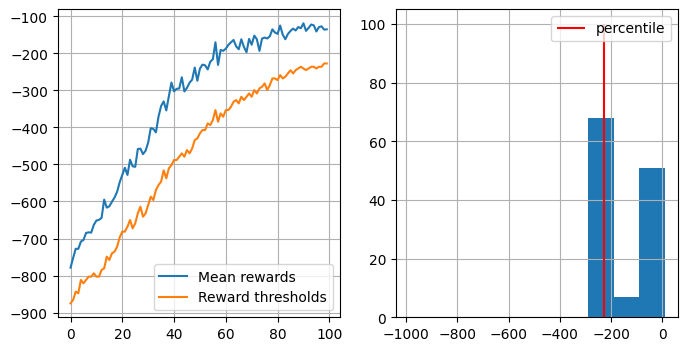

In [29]:
from IPython.display import Image, display

display(Image(filename='session20.png'))

n_sessions = 250  # sample this many sessions

percentile = 20 # discard this percentage of sessions with lowest rewards

learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

mean reward = -8.032, threshold=-13.000


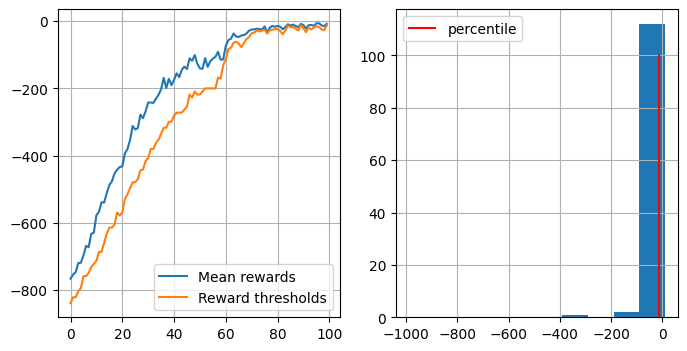

In [30]:
display(Image(filename='percentile20.png'))

n_sessions = 250  # sample this many sessions

percentile = 60 # discard this percentage of sessions with lowest 

learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

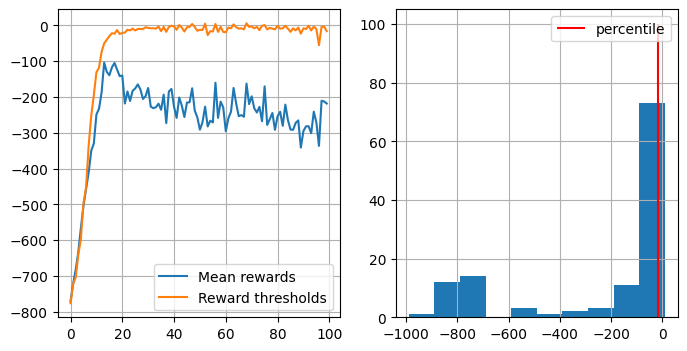

In [31]:
display(Image(filename='percentile60.png'))

n_sessions = 250  # sample this many sessions

percentile = 70 # discard this percentage of sessions with lowest 

learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

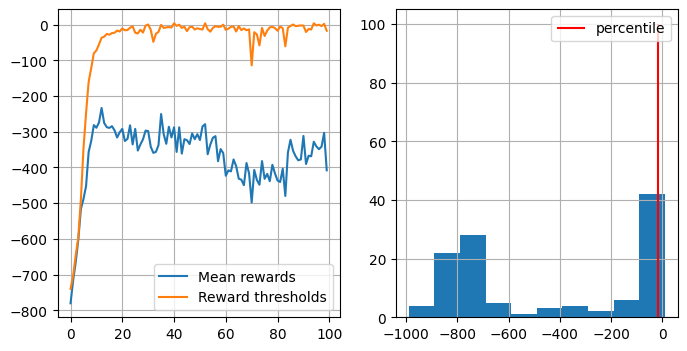

In [32]:
display(Image(filename='percentile70.png'))

We can see that a lower percentile gives us more information to learn because there is a lot of information. But a higher percentile gives us a faster reward to the agent, but in our case n_sessions is 250 and this is a bad combo for a high percentile as it takes time to learn due to lack of data. But in general lower percentile gives us more information + less risk of learning bad strategy, but slower training + slower reward generation. A high percentile is faster to find a good strategy, but higher chance of bad learning (since we forget previous information) + too dependent on other hyperparameters (e.g. in our case a higher n_session will probably give us a completely different result, I think the better one).

### Second experiment 


n_sessions = 500  # sample this many sessions

percentile = 50 # discard this percentage of sessions with lowest rewards

learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1



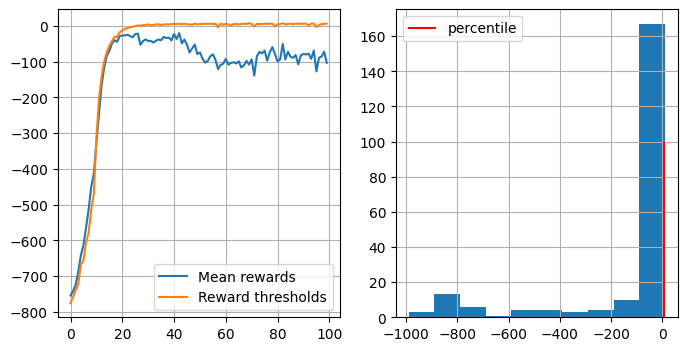

In [33]:
display(Image(filename='sessions500.png'))

n_sessions = 1500  # sample this many sessions

percentile = 50 # discard this percentage of sessions with lowest rewards

learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

mean reward = -94.357, threshold=7.000



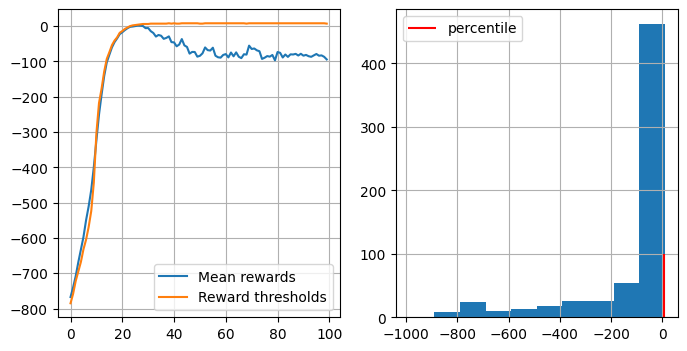

In [34]:
display(Image(filename='sessions1500.png'))

n_sessions = 5000  # sample this many sessions

percentile = 50 # discard this percentage of sessions with lowest rewards

learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

mean reward = -77.816, threshold=8.000


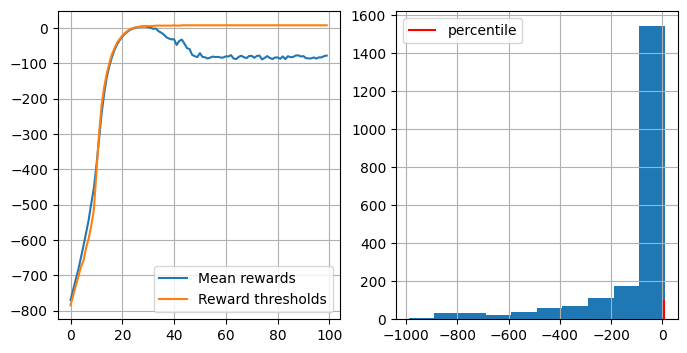

In [35]:
display(Image(filename='sessions5000.png'))

In general a small number of sessions (let's say up to 2000) are trained very quickly but the policy is updated on a small amount of data, there4 training is less stable + a lot of jumps, and in a large number of sessions, the model is trained more slowly but less random and better policy is updated. In our example, this can be seen in the fluctuation of the direct reward, but in general the learning is more stable than when the percentile changes

### Third experiment 


n_sessions = 1000  # sample this many sessions

percentile = 60 # discard this percentage of sessions with lowest rewards

learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

mean reward = -99.866, threshold=8.000



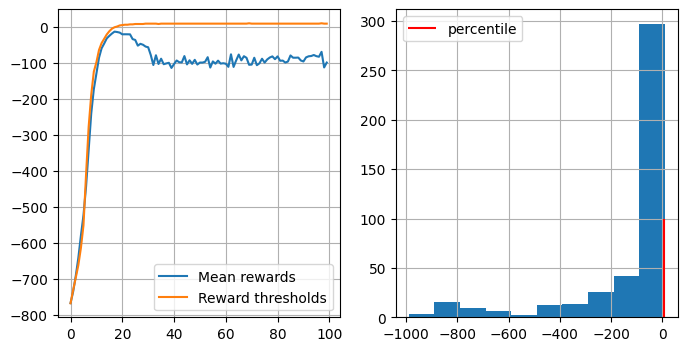

In [36]:
display(Image(filename='sess1000perc60.png'))

n_sessions = 5000  # sample this many sessions

percentile = 40 # discard this percentage of sessions with lowest rewards

learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

mean reward = -30.726, threshold=7.000

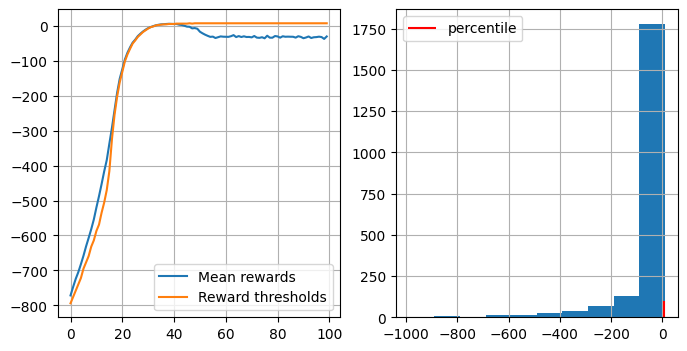

In [37]:
display(Image(filename='sess5000perc40.png'))

n_sessions = 5000  # sample this many sessions

percentile = 20 # discard this percentage of sessions with lowest rewards

learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

mean reward = 5.646, threshold=5.000


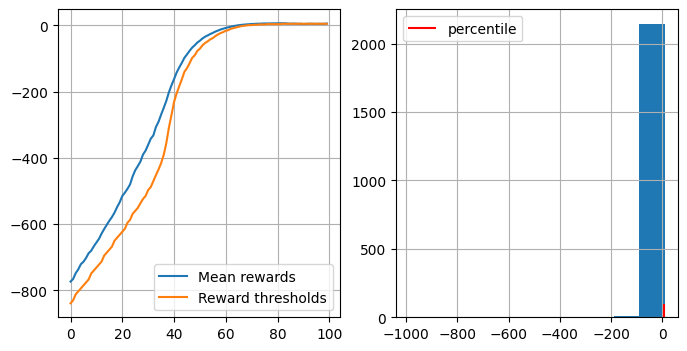

In [38]:
display(Image(filename='victory.png'))

We can see that our algorithm came up with positive score by reducing percentile (to take more strategies) and increasing number of session

## Task 1.2 

Above we can see that i found hyperparametrs for positive reward. I did not change the idea of existing code, only modified hyperparametrs for our algorithm. Below i will copy paste things that i've changed in the seminar notebook and also provide the picture

n_sessions = 5000  # sample this many sessions

percentile = 20 # discard this percentage of sessions with lowest rewards

learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

result: mean reward = 5.646, threshold=5.000


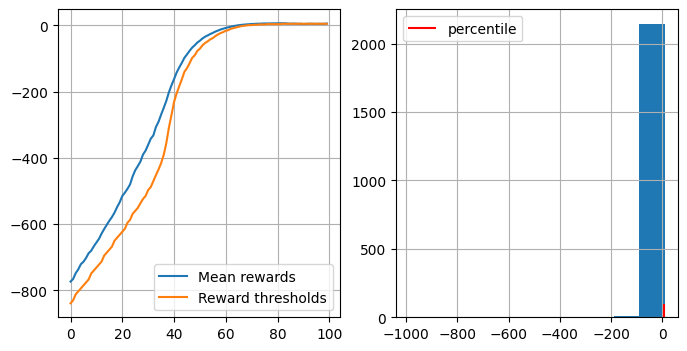

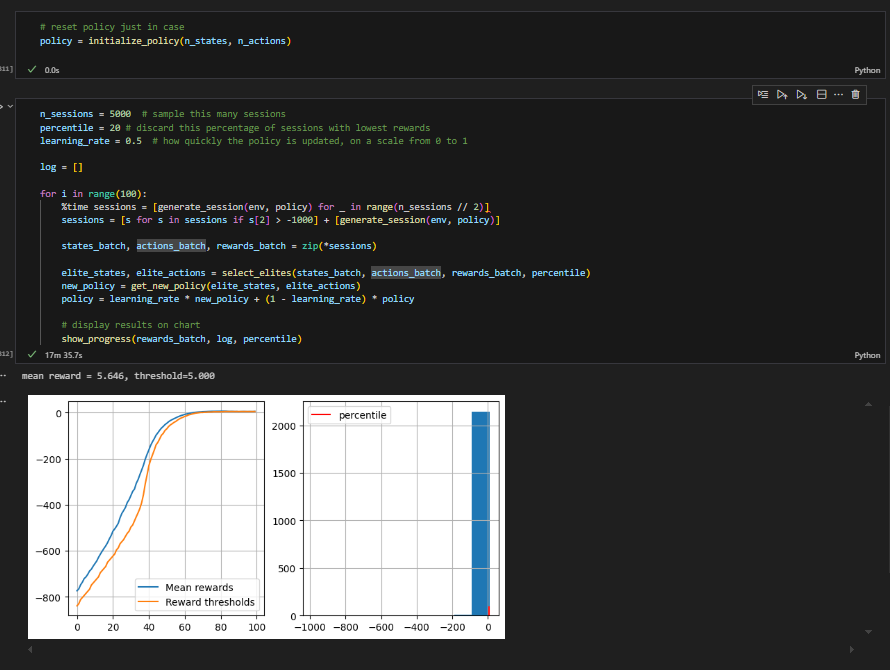

In [17]:
display(Image(filename='victory.png'))
display(Image(filename='code+picture.png'))

### Final review of task 1:
As I thought trying to change only one hyperparameter did not lead to serious improvements, but improved something instead of  making something else worse. I decided to try changing the number of sessions and percentiles. 

Recall that a large number of sessions gives more data for policy updates, less randomization and a small number of sessions only works faster. A high percentile is very demanding on the selection of sessions while a low percentile allows you to capture more sessions.

In our case where in fact an evolutionary algorithm that is quite simple to implement and work requires exactly a large number of sessions to accurately evaluate all strategies. In the pair with a large number of sessions I added a low percentile because the work has a randomized part I found it necessary in our case to capture more strategies adding to large number of sessions.  This way the agent did not lose any useful strategies. This can be seen since it started to converge and reach a positive reward only towards the end so a low percentile combined with a large number of sessions justified itself in our task.

# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gymnasium pages: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

## Task 2.1 MountainCar-v0

Firstly let's make an env for our game

In [70]:
env = gym.make("MountainCar-v0").env  
state_dim = env.observation_space.shape[0] # size of the state space 
n_actions = env.action_space.n # number of actions
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

state vector dim = 2
n_actions = 3


Our agent will clasife states using multilayerpercetronn (MLP just fully connected nn). MLP will get [pos, velocity] state and give back prob for action (0 left, 1 do nothin, 2 go right). I will use 2 hidden layers64 64

In [71]:
agent = MLPClassifier(
    hidden_layer_sizes=(64, 64),  
    activation="tanh",
    warm_start=True,
)
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


MLPClassifier(activation='tanh', hidden_layer_sizes=(64, 64), warm_start=True)

In [72]:
def generate_session(seed):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """

    np.random.seed(seed)
    local_env = gym.make("MountainCar-v0").env 

    states, actions = [], []
    total_reward = 0
    state, _ = local_env.reset()

    for _ in range(10000):  
        probs = agent.predict_proba([state])[0]
        action = np.random.choice(n_actions, p=probs)

        new_state, reward, done, _, _ = local_env.step(action)

        states.append(state)
        actions.append(action)
        total_reward += reward

        state = new_state
        if done:
            break

    local_env.close()
    return states, actions, total_reward

In [73]:
def parallel_generate_sessions(n_sessions):
    with mp.Pool(mp.cpu_count()) as pool:
        sessions = pool.map(generate_session, range(n_sessions))
    return zip(*sessions)


In [74]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    threshold = np.percentile(rewards_batch, q=percentile)
    elite_states, elite_actions = [], []

    for i in range(len(rewards_batch)):
        if rewards_batch[i] > threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return np.array(elite_states, dtype=np.float32), np.array(elite_actions, dtype=np.float32)

In [75]:
def show_progress(rewards_batch, log, percentile):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=[-200, 0])
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


In [76]:
n_sessions = 200
percentile = 50
log = []

mean reward = -145.100, threshold=-141.000


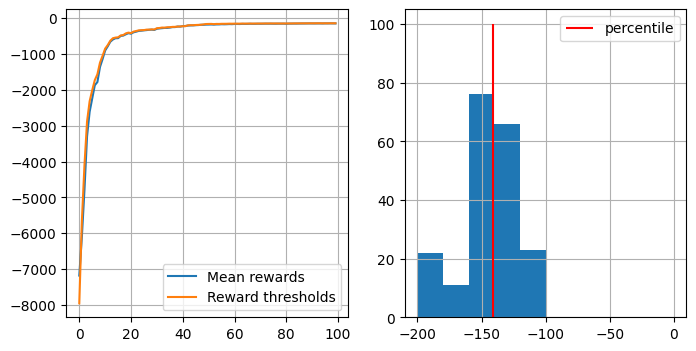

In [77]:
for i in range(100):
    states_batch, actions_batch, rewards_batch = parallel_generate_sessions(n_sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    if len(elite_states) > 0:
        agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile)
    if np.mean(rewards_batch) > -140:
        print("Target achieved!")
        break

env.close()

In [78]:
import imageio
env = gym.make("MountainCar-v0", render_mode="rgb_array").env  
frames = []

state, _ = env.reset()
for _ in range(10000):  
    frame = env.render() 
    frame = np.array(frame) 
    frame = frame[:, :608]  
    frames.append(frame)  

    action = agent.predict([state])[0]
    state, _, done, _, _ = env.step(action)
    if done:
        break

env.close()

imageio.mimsave("mountaincar.mp4", frames, fps=30)

error: XDG_RUNTIME_DIR not set in the environment.
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x20891a80] Warning: data is not aligned! This can lead to a speed loss


In [81]:
from IPython.display import HTML
video_path = "mountaincar.mp4"
HTML(f"""
<video width="640" height="480" controls>
  <source src="{video_path}" type="video/mp4">
</video>
""")

So we can see, that mlp w 2 hidd 64 64 and parallized learning gave us -150 and i achieved goal for the task. I did explain how mpl working in my task and now i wanna explain why i decided to use multiprocessing. Firstly i tried to learn without it and found out that it requires a lot of time so i decided to parallize it. I make a pool of processors and run the game in parallel. Every process get their local env (btw games can noot be equal since i use random seed). This decision helped me to achieve -150, even considering the fact that in the beginning my learning was very random so it took some time to stabilize. so im done with this task

## Task 2.2 MountainCar-v0

I've already used multiprocessing library but let's try to switch to the joblib (at least it is advised to do so). Logic for parallel computin stays the same for task 2.1 and task 2.2. Also it is advised to reuse samples (basically cache last 3-5 iterations) i will keep last 3- 5 iterations


In [110]:
import joblib
from joblib import Parallel, delayed


In [111]:
n_sessions = 100
percentile = 70
t_max = 10**4
log = []
past_sessions = []

In [112]:
env = gym.make("MountainCar-v0", render_mode="rgb_array").env
state_dim = env.observation_space.shape[0] # size of the state space 
n_actions = env.action_space.n # number of actions
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

state vector dim = 2
n_actions = 3


In [113]:
agent = MLPClassifier(
    hidden_layer_sizes=(64, 64),  
    activation="tanh",
    warm_start=True,
)
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


MLPClassifier(activation='tanh', hidden_layer_sizes=(64, 64), warm_start=True)

In [114]:
def generate_session(seed):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """

    np.random.seed(seed)
    local_env = gym.make("MountainCar-v0", render_mode="rgb_array").env

    states, actions = [], []
    total_reward = 0
    state, _ = local_env.reset()

    for _ in range(t_max):
        probs = agent.predict_proba([state])[0]
        action = np.random.choice(n_actions, p=probs)

        new_state, reward, done, _, _ = local_env.step(action)

        states.append(state)
        actions.append(action)
        total_reward += reward

        state = new_state
        if done:
            break

    local_env.close()
    return states, actions, total_reward

In [115]:
def parallel_generate_sessions(n_sessions):
    results = Parallel(n_jobs=joblib.cpu_count())(delayed(generate_session)(i) for i in range(n_sessions))
    return zip(*results)

In [116]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    global past_sessions

    past_sessions.append((states_batch, actions_batch, rewards_batch))
    if len(past_sessions) > 5:
        past_sessions.pop(0)  

    all_states, all_actions, all_rewards = [], [], []
    for s_batch, a_batch, r_batch in past_sessions[-3:]:  
        all_states.extend(s_batch)
        all_actions.extend(a_batch)
        all_rewards.extend(r_batch)

    threshold = np.percentile(all_rewards, q=percentile)

    elite_states, elite_actions = [], []
    for i in range(len(rewards_batch)):
        if rewards_batch[i] > threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return np.array(elite_states, dtype=np.float32), np.array(elite_actions, dtype=np.float32)

In [117]:
def show_progress(rewards_batch, log, percentile):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=[-200, 0])
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


mean reward = -143.320, threshold=-136.000


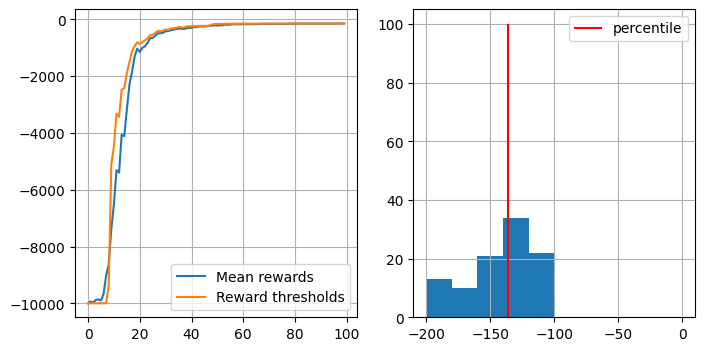

In [118]:
for i in range(100):
    states_batch, actions_batch, rewards_batch = parallel_generate_sessions(n_sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    if len(elite_states) > 0:
        agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile)
    
    if np.mean(rewards_batch) >= -100:
        print("Target achieved!")
        break

env.close()

Я уже не успеваю писать на англ, но вот что вышло: я попытался придумать эвристики с глубокими сетками, динамическим изменением перцентиля и даже докинул награды за правильную работу, но все это выдавало мне ужасную награду. Я думаю что таким вещам требуется либо очень долгое обучени, либо прямые руки автора (ну я не исключаю что писал херню), так что вышло, то что вышло. Наверное если подкрутить сюда большее кол-во сессий то я смог бы еще сильнее уменшить награду, но увы не сегодня(

In [119]:
# def visualize_mountain_car(env, agent):
#     # Compute policy for all possible x and v (with discretization)
#     xs = np.linspace(env.min_position, env.max_position, 100)
#     vs = np.linspace(-env.max_speed, env.max_speed, 100)

#     grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
#     grid_flat = grid.reshape(len(xs) * len(vs), 2)
#     probs = (
#         agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)
#     )

#     # # The above code is equivalent to the following:
#     # probs = np.empty((len(vs), len(xs), 3))
#     # for i, v in enumerate(vs[::-1]):
#     #     for j, x in enumerate(xs):
#     #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

#     # Draw policy
#     f, ax = plt.subplots(figsize=(7, 7))
#     ax.imshow(
#         probs,
#         extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed),
#         aspect="auto",
#     )
#     ax.set_title("Learned policy: red=left, green=nothing, blue=right")
#     ax.set_xlabel("position (x)")
#     ax.set_ylabel("velocity (v)")

#     # Sample a trajectory and draw it
#     states, actions, _ = generate_session(env, agent)
#     states = np.array(states)
#     ax.plot(states[:, 0], states[:, 1], color="white")

#     # Draw every 3rd action from the trajectory
#     for (x, v), a in zip(states[::3], actions[::3]):
#         if a == 0:
#             plt.arrow(x, v, -0.1, 0, color="white", head_length=0.02)
#         elif a == 2:
#             plt.arrow(x, v, 0.1, 0, color="white", head_length=0.02)


# with gym.make("MountainCar-v0", render_mode="rgb_array").env.unwrapped as env:
#     visualize_mountain_car(env, agent)



### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) (90+ pts to solve), [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) (`env = gym.make("LunarLander-v2", continuous=True)`)(200+ pts to solve)
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.